In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

In [2]:
scada_data = pd.read_csv("C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt", delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
scada_data.index = scada_data['dtTimeStamp']

single_sensor_wind_speed = scada_data[scada_data["intObjectId"] == 1748][["WindSpeedMean"]]
single_sensor_wind_speed.dropna(inplace=True)
print(single_sensor_wind_speed.head(5))

                     WindSpeedMean
dtTimeStamp                       
2019-08-01 00:00:00            3.0
2019-08-01 00:10:00            3.2
2019-08-01 00:20:00            4.7
2019-08-01 00:30:00            6.0
2019-08-01 00:40:00            6.2


## Rolling statistics
If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.

In [3]:
rolling_window_size = 72

### Rolling Mean

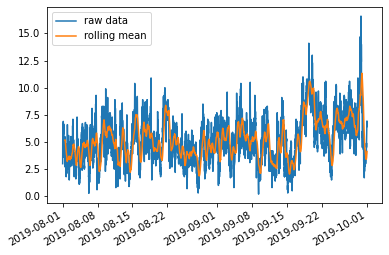

In [4]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["WindSpeedMean"], label='raw data')
ax.plot(single_sensor_wind_speed["WindSpeedMean"].rolling(window=rolling_window_size).mean(), label="rolling mean");
ax.legend()
fig.autofmt_xdate()

#### Standardized / Detrended Rolling Mean

In [5]:
single_sensor_wind_speed['z_data'] = (single_sensor_wind_speed['WindSpeedMean'] - single_sensor_wind_speed['WindSpeedMean'].rolling(window=rolling_window_size).mean()) / single_sensor_wind_speed['WindSpeedMean'].rolling(window=rolling_window_size).std()

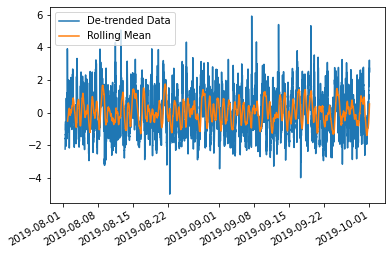

In [6]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed['z_data'], label="De-trended Data")
ax.plot(single_sensor_wind_speed['z_data'].rolling(window=rolling_window_size).mean(), label="Rolling Mean");
ax.legend()
fig.autofmt_xdate()

#### Differenced De-Trended Rolling Mean

In [7]:
single_sensor_wind_speed['zp_data'] = single_sensor_wind_speed['z_data'] - single_sensor_wind_speed['z_data'].shift(rolling_window_size)

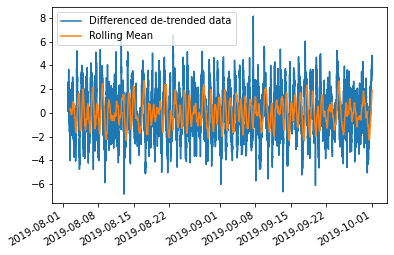

In [8]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed['zp_data'], label="Differenced de-trended data")
ax.plot(single_sensor_wind_speed['zp_data'].rolling(window=rolling_window_size).mean(), label="Rolling Mean");
ax.legend()
fig.autofmt_xdate()

### Rolling Standard Deviation

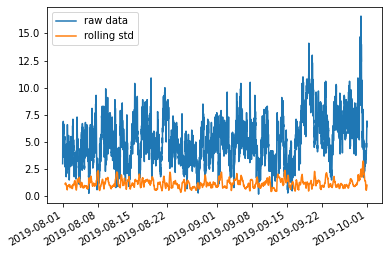

In [9]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["WindSpeedMean"], label='raw data')
ax.plot(single_sensor_wind_speed["WindSpeedMean"].rolling(window=rolling_window_size).std(), label="rolling std");
ax.legend()
fig.autofmt_xdate()

#### De-Trended Rolling Standard Deviation

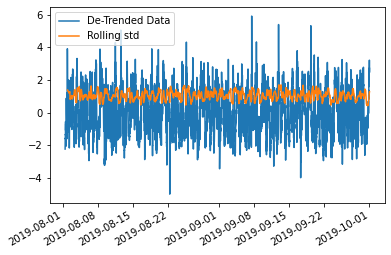

In [10]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["z_data"], label="De-Trended Data")
ax.plot(single_sensor_wind_speed["z_data"].rolling(window=rolling_window_size).std(), label="Rolling std");
ax.legend()
fig.autofmt_xdate()

#### Differenced De-Trended Stand Deviation

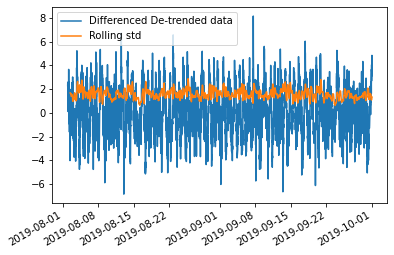

In [11]:
fig, ax = plt.subplots()
ax.plot(single_sensor_wind_speed.index, single_sensor_wind_speed["zp_data"], label="Differenced De-trended data")
ax.plot(single_sensor_wind_speed["zp_data"].rolling(window=rolling_window_size).std(), label="Rolling std");
ax.legend()
fig.autofmt_xdate()

### Augmented Dickey-Fuller Test

In [12]:
from statsmodels.tsa.stattools import adfuller



print(" > Is the data stationary ?")
dftest = adfuller(single_sensor_wind_speed["WindSpeedMean"], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(single_sensor_wind_speed.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print(f"\n > Is the {rolling_window_size}-lag differenced de-trended data stationary ?")
dftest = adfuller(single_sensor_wind_speed.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -8.360
P-value = 0.000
Critical values :
	1%: -3.431097311639354 - The data is  stationary with 99% confidence
	5%: -2.861870262109275 - The data is  stationary with 95% confidence
	10%: -2.5669457935471884 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -14.005
P-value = 0.000
Critical values :
	1%: -3.43110464208646 - The data is  stationary with 99% confidence
	5%: -2.8618735012686005 - The data is  stationary with 95% confidence
	10%: -2.5669475177740573 - The data is  stationary with 90% confidence

 > Is the 72-lag differenced de-trended data stationary ?
Test statistic = -13.668
P-value = 0.000
Critical values :
	1%: -3.4311109648492004 - The data is  stationary with 99% confidence
	5%: -2.8618762951485057 - The data is  stationary with 95% confidence
	10%: -2.5669490049767214 - The data is  stationary with 90% confidence


#### KPSS

In [13]:
from statsmodels.tsa.stattools import kpss

for column in ["WindSpeedMean", 'z_data', "zp_data"]:
    print(column)
    statistic, p_value, n_lags, critical_values = kpss(single_sensor_wind_speed[column].dropna())
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n')


WindSpeedMean
KPSS Statistic: 3.2043306853058775
p-value: 0.01
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary

z_data
KPSS Statistic: 0.011051708204285833
p-value: 0.1
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary

zp_data
KPSS Statistic: 0.00408998204273961
p-value: 0.1
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary



C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values 

#### Autocorrelation plots (ACF & PACF)

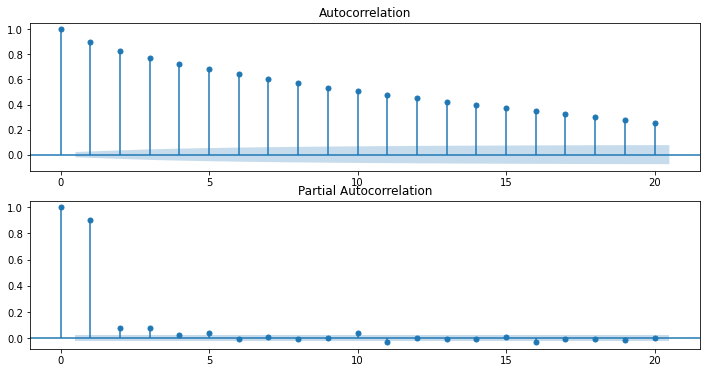

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(single_sensor_wind_speed.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(single_sensor_wind_speed.z_data.dropna(), ax=ax[1], lags=20)